[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Entrenamiento de una YOLOv11 sobre un corpus propio

---

YOLO11 se basa en los avances introducidos en YOLOv9 y YOLOv10 a principios de este año, incorporando diseños arquitectónicos mejorados, técnicas de extracción de características optimizadas y métodos de entrenamiento perfeccionados.

YOLO11m logra una puntuación mAP media más alta en el conjunto de datos COCO utilizando un 22% menos de parámetros que YOLOv8m, lo que lo hace computacionalmente más ligero sin sacrificar rendimiento.

YOLOv11 está disponible en 5 tamaños diferentes, desde `2.6M` a `56.9M` de parámetros, siendo capaz de obtener desde `39.5` a `54.7` de mAP sobre el dataset COCO.

GRUPO : MARIANELA PI - ROBERTO GARCIA - IVANA PORTO

Revisamos la GPU a la que nos conectamos (si no aparece ninguna, cambiar la máquina virtual del 'Entorno de ejecución')

In [1]:
!nvidia-smi

Fri Nov 15 20:09:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Instalación de YOLO11 desde Ultralytics

In [4]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


## Uso out-of-the-box

Vamos a usar el modelo más pequeño para hacer inferencia y que nos dé todas las detecciones de las clases que ya tiene pre-entrenadas (dataset COCO).

Debemos subir una imagen cualquiera a la carpeta raíz y ponerle de nombre 'calle1.jpg'

In [5]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/calle1.jpg' save=True

100% 5.35M/5.35M [00:00<00:00, 329MB/s]
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/calle1.jpg: 384x640 14 persons, 62.4ms
Speed: 12.3ms preprocess, 62.4ms inference, 828.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


El resultado queda en la carpeta /runs/detect/predict, que va agregando números al final cada vez que hacemos una nueva inferencia, ej: /predict1, /predict2, etc., de manera de no perder los resultados previos.

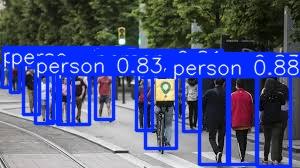

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/calle1.jpg', width=600)

**Sobre una imagen de una empanada**

Queremos ver ahora cómo se comporta en la detección de una empanada (clase no presente en el dataset COCO!)

In [7]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/empanada-prueba.jpg' save=True

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/empanada-prueba.jpg: 512x640 1 sandwich, 1 hot dog, 48.8ms
Speed: 4.7ms preprocess, 48.8ms inference, 591.9ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


(ACORDARSE! revisar en el log de la inferencia en qué carpeta guardó el resultado, para actualizar la línea siguiente)

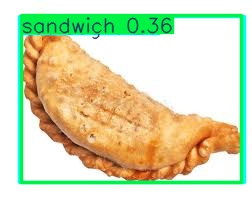

In [9]:
IPyImage(filename=f'{HOME}/runs/detect/predict2/empanada-prueba.jpg', width=600)

La clase empanada no esta dentro del dataset COCO por lo que detecta la imagen como un sandwich

## Fine-tuning de una YOLO11 nano sobre el dataset propio

Importamos ahora el dataset generado en Roboflow con las imágenes de empanadas y con la única clase a detectar 'empanada'

In [10]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PBWIUQBcRcutzVaXIRgR")
project = rf.workspace("ivana-workspace").project("deteccion-empanadas")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteccion-empanadas-1 in yolov11:: 100%|██████████| 163/163 [00:00<00:00, 4632.74it/s]


## Re-entrenamiento

In [11]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=70 imgsz=640 plots=True

/content
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Deteccion-empanadas-1/data.yaml, epochs=70, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

El número de epochs fue modificado de 50 a 70 ya que en primera instancia probamos con 50 epochs seguía reconociendo la imagen de prueba como sándwich. Una vez que incrementamos las epochs a 70 etiquetó correctamente el objeto con una confianza del 85%.

Resultados del entrenamiento (con gráficas de desempeño) en `{HOME}/runs/detect/train/`, vamos a examinarlas.

In [12]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      train_batch300.jpg
confusion_matrix.png				    R_curve.png       train_batch301.jpg
events.out.tfevents.1731701534.ecb322f218a4.1125.0  results.csv       train_batch302.jpg
F1_curve.png					    results.png       val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					    train_batch1.jpg  weights


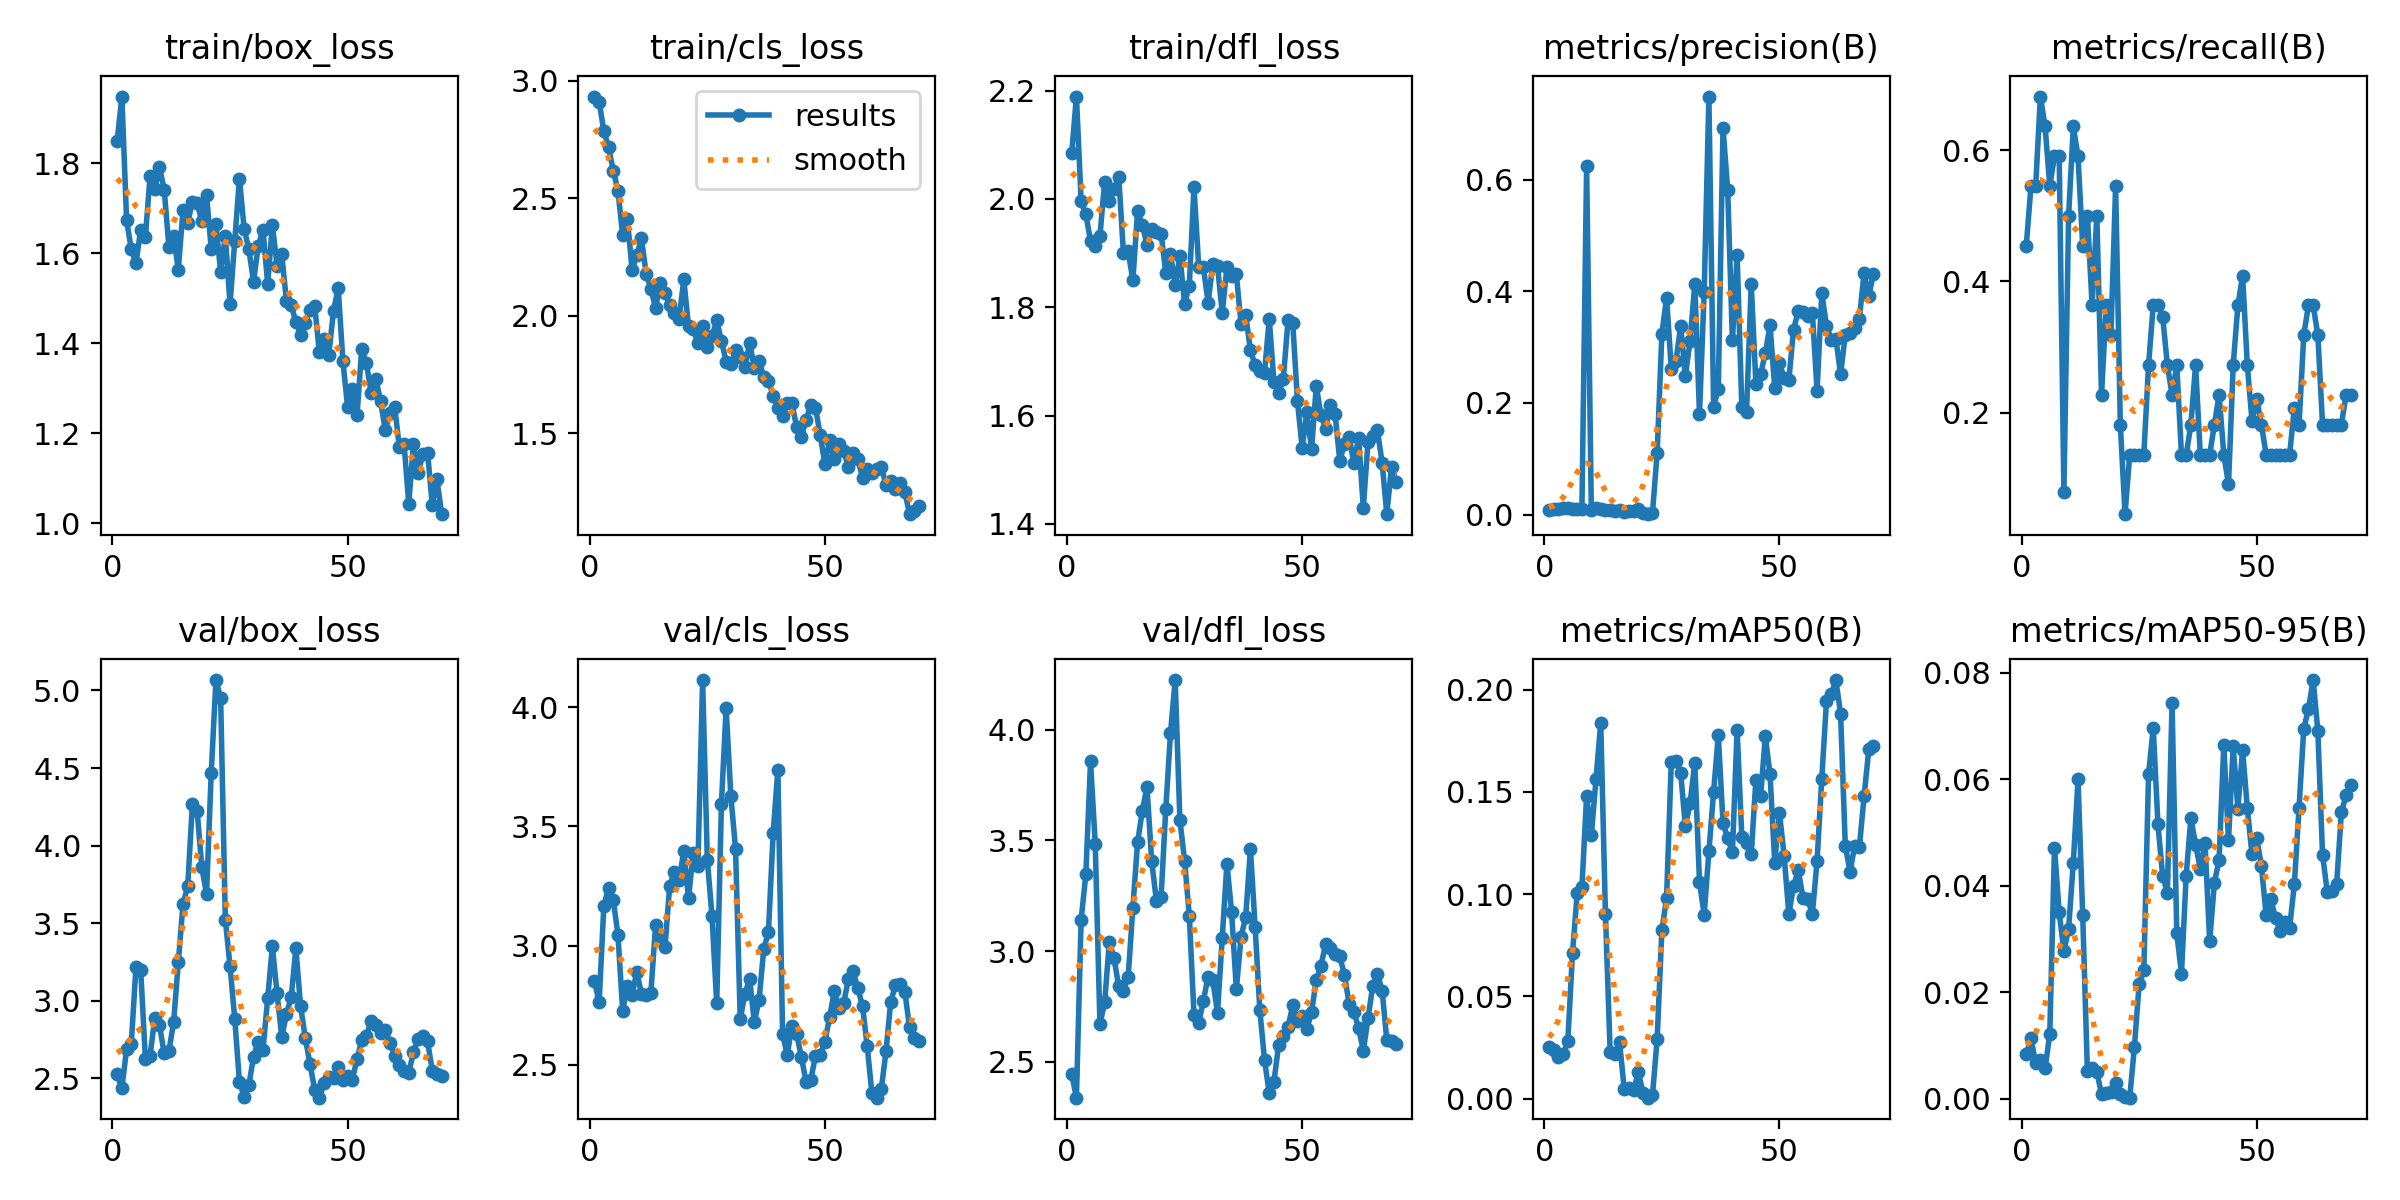

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=800)

train/box_loss: La pérdida de las cajas delimitadoras disminuye indicando mejor localización de los objetos.
train/cls_loss: La pérdida de clasificación baja, el modelo aprende a etiquetar correctamente.
metrics/precision(B): La precisión mejora gradualmente .
metrics/recall(B): El recall fluctúa, pero tiende a mejorar con más epochs.


Vemos ahora la detección sobre las imágenes de validación.

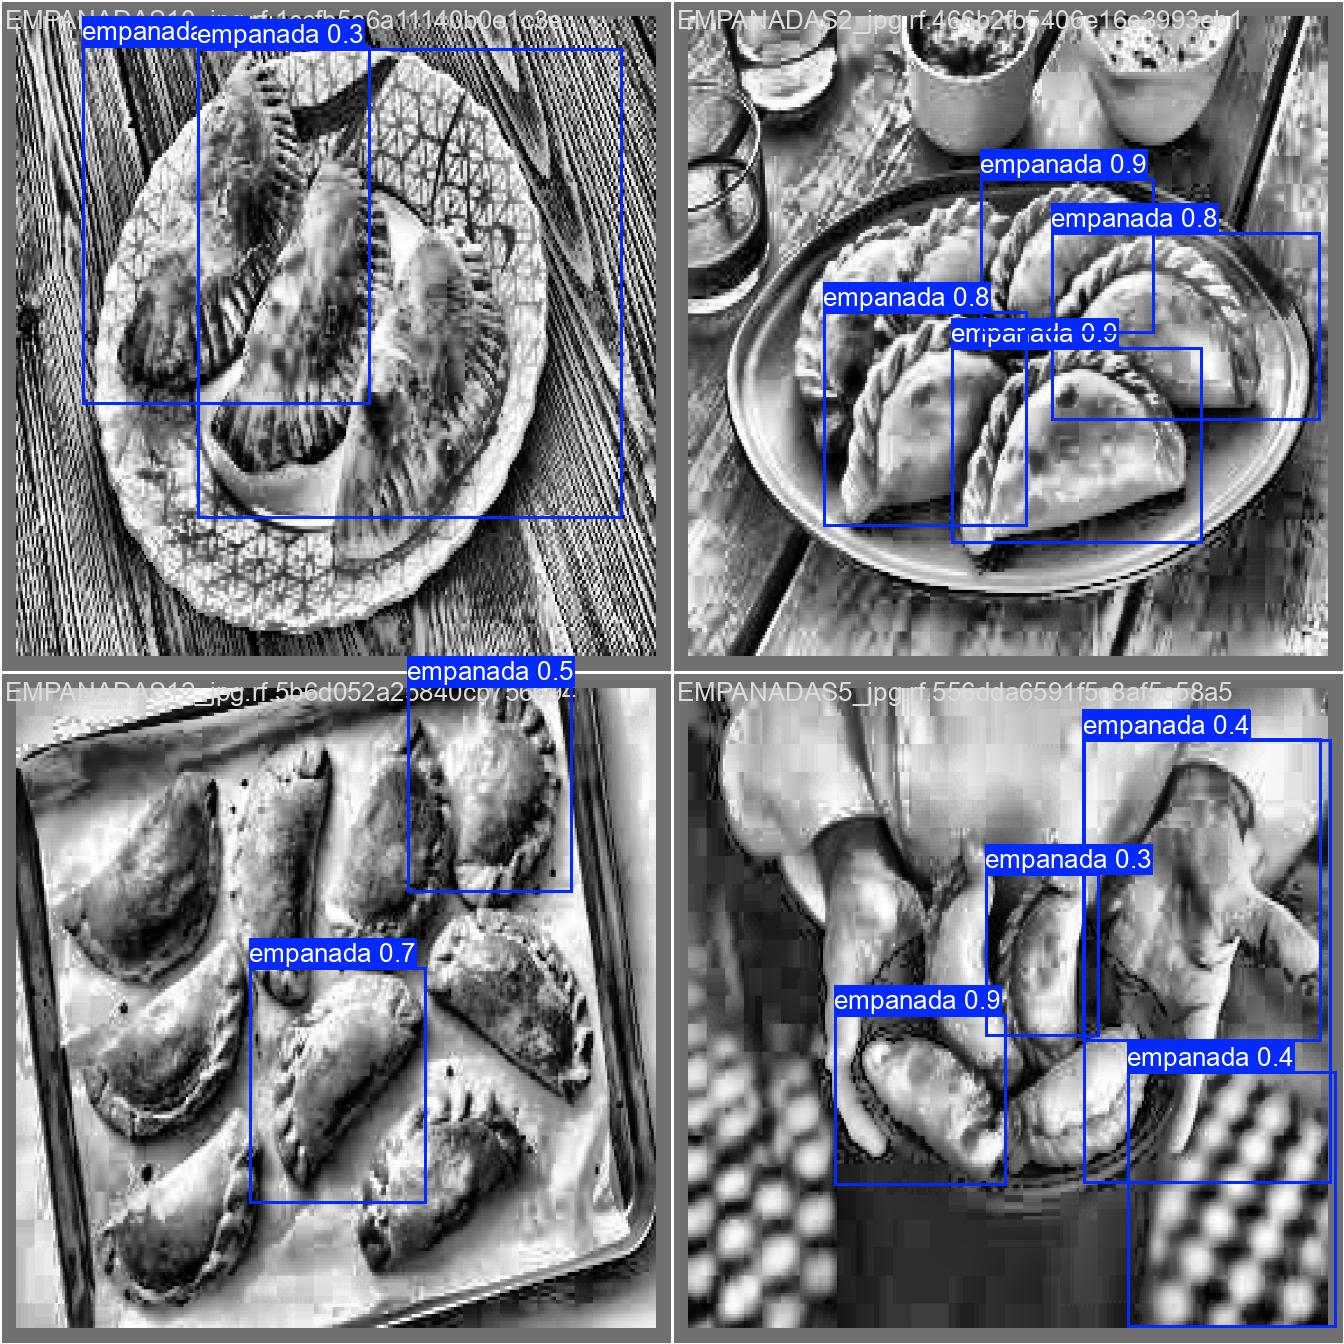

In [14]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Inferencia sobre imágenes de test

Corremos ahora la detección sobre las imágenes de test (no vistas en el entrenamiento)

In [15]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/2 /content/Deteccion-empanadas-1/test/images/EMPANADAS14_jpg.rf.31b777d23b2615e75171b39559f243b9.jpg: 640x640 1 empanada, 12.4ms
image 2/2 /content/Deteccion-empanadas-1/test/images/EMPANADAS17_jpg.rf.9d104fef2d3e013574524ae2dece3aed.jpg: 640x640 3 empanadas, 10.8ms
Speed: 2.5ms preprocess, 11.6ms inference, 331.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


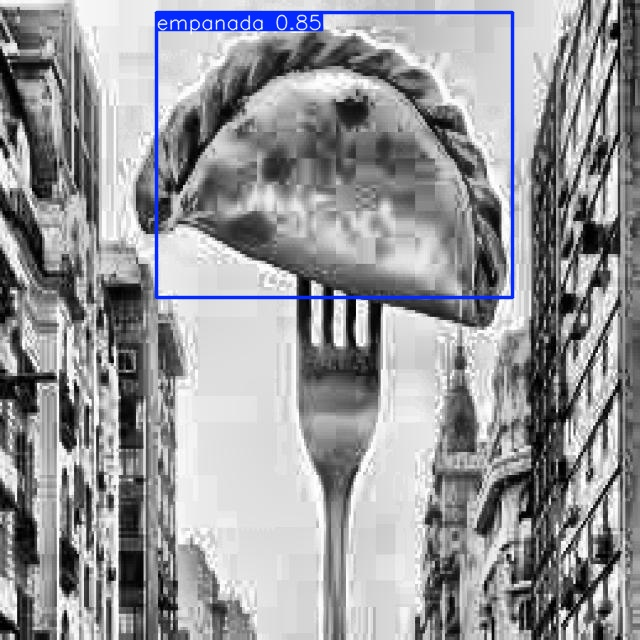

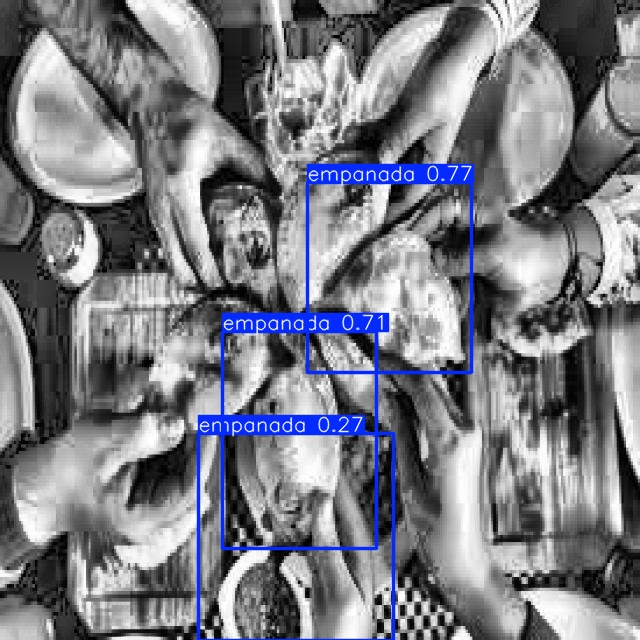

In [16]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Imagen adicional para prueba

Bajar una imagen nueva y subirla al directorio raíz, luego hacer inferencia y mostrar resultados.

En el código, cambiar la imagen en la variable **source**

ACORDARSE!: si se hicieron varios entrenamientos, los pesos van quedando en carpetas con numeración sucesiva /train1, /train2, etc., revisar que se esté usando la última carpeta entrenada en la variable **model**.

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/empanada-prueba.jpg: 512x640 1 empanada, 48.0ms
Speed: 4.1ms preprocess, 48.0ms inference, 551.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict
Results saved to: /content/runs/detect/predict4/


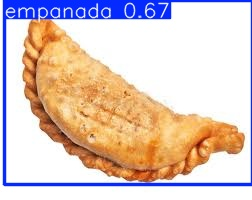

In [17]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/empanada-prueba.jpg save=True

latest_predict_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
print(f"Results saved to: {latest_predict_folder}")
# Display the results

from IPython.display import Image as IPyImage, display
for img in glob.glob(f'{latest_predict_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))
    print("\n")

Se realizó un ajuste en el entrenamiento del modelo, aumentando el número de épocas de 50 a 70. Este cambio se justificó debido a una mejora observada en la confianza del modelo y las métricas de desempeño en la tarea de detección de imágenes.

Resultados Observados:

Pérdidas de Entrenamiento y Validación:

Las gráficas de pérdidas (box_loss, cls_loss, dfl_loss) muestran una tendencia decreciente tanto en entrenamiento como en validación.
A partir de las 50 épocas, las pérdidas continúan disminuyendo, lo que evidencia que el modelo sigue aprendiendo.

Precisión y Recall:

La precisión y el recall (precision(B) y recall(B)) presentan incrementos  tras las 50 épocas, lo que indica una mejora en la detección de los objetos.
Aunque estas métricas son algo fluctuantes, la tendencia general es positiva.